In [14]:
import pylab
import concurrent.futures
import multiprocessing as mp
import numpy as np
from scipy.linalg import expm

from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.classical import expr
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer.primitives import Sampler

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.circuit.library import HartreeFock

from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_algorithms import IterativePhaseEstimation

from qiskit_ibm_runtime import QiskitRuntimeService

In [15]:
def compute_energy(i, distance, algorithm):
    driver = PySCFDriver(
        atom=f'H .0 .0 .0; H .0 .0 {distance}',
        unit=DistanceUnit.ANGSTROM,
        charge=0,
        spin=0,
        basis='sto3g'
    )

    molecule = driver.run()
    mapper = ParityMapper(num_particles=molecule.num_particles)
    fer_op = molecule.hamiltonian.second_q_op()
    tapered_mapper = molecule.get_tapered_mapper(mapper)
    qubit_op = tapered_mapper.map(fer_op)
    return qubit_op
cost_h=compute_energy(0, 0.742, None)
print(cost_h)
print(type(cost_h))


SparsePauliOp(['I', 'Z', 'X'],
              coeffs=[-1.04259702+0.j, -0.78723106+0.j, -0.18132241+0.j])
<class 'qiskit.quantum_info.operators.symplectic.sparse_pauli_op.SparsePauliOp'>


In [16]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np

def build_driver_hamiltonian(n_qubits):
    pauli_strings = []
    coefficients = []

    for i in range(n_qubits):
        # 构造类似 'XIII', 'IXII', 'IIXI', 'IIIX'
        pauli_str = ['I'] * n_qubits
        pauli_str[i] = 'X'
        pauli_strings.append("".join(pauli_str))
        coefficients.append(-1.0)

    return SparsePauliOp(pauli_strings, coeffs=np.array(coefficients))

# 示例：4-qubit 系统
driver_h = build_driver_hamiltonian(4)

print(driver_h)
print(type(driver_h))


SparsePauliOp(['XIII', 'IXII', 'IIXI', 'IIIX'],
              coeffs=[-1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j])
<class 'qiskit.quantum_info.operators.symplectic.sparse_pauli_op.SparsePauliOp'>


In [17]:
from qiskit.quantum_info import SparsePauliOp

def commutator(opA: SparsePauliOp, opB: SparsePauliOp) -> SparsePauliOp:
    return (opA @ opB) - (opB @ opA)


In [18]:
def expand_operator(op: SparsePauliOp, target_qubits: int) -> SparsePauliOp:
    """将 op 扩展为作用在 target_qubits 上的 SparsePauliOp"""
    expanded_paulis = []
    for p in op.paulis.to_labels():
        # pad with identity on the right（或左，根据你想的位置）
        padded_p = p.ljust(target_qubits, 'I')  # 右侧补 I
        expanded_paulis.append(padded_p)
    return SparsePauliOp(expanded_paulis, coeffs=op.coeffs)


In [19]:
cost_h_expanded = expand_operator(cost_h, 4)

comm_h = commutator(driver_h, cost_h_expanded)

print(comm_h)
print(type(comm_h))


SparsePauliOp(['XIII', 'YIII', 'IIII', 'IXII', 'ZXII', 'XXII', 'IIXI', 'ZIXI', 'XIXI', 'IIIX', 'ZIIX', 'XIIX', 'XIII', 'IXII', 'IIXI', 'IIIX', 'YIII', 'ZXII', 'ZIXI', 'ZIIX', 'IIII', 'XXII', 'XIXI', 'XIIX'],
              coeffs=[ 1.04259702+0.j        , -0.        -0.78723106j,  0.18132241+0.j        ,
  1.04259702+0.j        ,  0.78723106+0.j        ,  0.18132241+0.j        ,
  1.04259702+0.j        ,  0.78723106+0.j        ,  0.18132241+0.j        ,
  1.04259702+0.j        ,  0.78723106+0.j        ,  0.18132241+0.j        ,
 -1.04259702+0.j        , -1.04259702+0.j        , -1.04259702+0.j        ,
 -1.04259702+0.j        , -0.        -0.78723106j, -0.78723106+0.j        ,
 -0.78723106+0.j        , -0.78723106+0.j        , -0.18132241+0.j        ,
 -0.18132241+0.j        , -0.18132241+0.j        , -0.18132241+0.j        ])
<class 'qiskit.quantum_info.operators.symplectic.sparse_pauli_op.SparsePauliOp'>


In [20]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli
from numpy import pi

def falqon_layer_qiskit(n_qubits, beta_k, cost_h, driver_h, delta_t):
    qc = QuantumCircuit(n_qubits)

    def apply_pauli_rotation(qc, pauli_label, coeff, factor):
        """将 exp(-i * coeff * factor * Pauli) 添加到电路"""
        op = Pauli(pauli_label)
        angle = 2 * coeff.real * factor  # Qiskit 是 Rz(θ) = exp(-iθZ/2)，所以用 2*θ
        qc.p(0, 0)  # 防止空电路
        qc.compose(
            PauliSumOp.from_list([(pauli_label, angle)]).exp_i().to_circuit(), inplace=True
        )

    # 应用 cost Hamiltonian 的演化
    for pauli_label, coeff in zip(cost_h.paulis.to_labels(), cost_h.coeffs):
        apply_pauli_rotation(qc, pauli_label, coeff, delta_t*beta_k)

    # 应用 driver Hamiltonian 的演化
    for pauli_label, coeff in zip(driver_h.paulis.to_labels(), driver_h.coeffs):
        apply_pauli_rotation(qc, pauli_label, coeff, beta_k * delta_t)

    return qc


In [21]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Statevector, Pauli
import numpy as np
import matplotlib.pyplot as plt


In [22]:
def apply_pauli_exp(circuit, pauli_string, angle):
    """在给定电路上应用单个 Pauli 项的 exp(-i * angle * P)"""
    n_qubits = circuit.num_qubits
    op = Pauli(pauli_string)

    # 将 Pauli 门转化为量子门：先变换到Z轴，再Rz，再变换回来
    qubits = [i for i, p in enumerate(pauli_string) if p != 'I']
    if not qubits:
        return

    for i in qubits:
        if pauli_string[i] == 'X':
            circuit.h(i)
        elif pauli_string[i] == 'Y':
            circuit.sdg(i)
            circuit.h(i)
        # Z 无需变换

    circuit.rz(2 * angle, qubits[-1])  # 控制Z旋转

    for i in reversed(qubits):
        if pauli_string[i] == 'X':
            circuit.h(i)
        elif pauli_string[i] == 'Y':
            circuit.h(i)
            circuit.s(i)


In [23]:
def build_ansatz(beta_list, cost_h: SparsePauliOp, driver_h: SparsePauliOp, delta_t: float):
    n_qubits = cost_h.num_qubits
    qc = QuantumCircuit(n_qubits)

    # 初始Hadamard
    for q in range(n_qubits):
        qc.h(q)

    for beta_k in beta_list:
        for p_str, c in zip(cost_h.paulis.to_labels(), cost_h.coeffs):
            apply_pauli_exp(qc, p_str, c.real * delta_t)
        for p_str, c in zip(driver_h.paulis.to_labels(), driver_h.coeffs):
            apply_pauli_exp(qc, p_str, c.real * beta_k * delta_t)

    return qc


In [24]:
def measure_expectation(qc: QuantumCircuit, hamiltonian: SparsePauliOp):
    state = Statevector(qc)
    return np.real(state.expectation_value(hamiltonian))


In [25]:
def falqon_qiskit(n, beta_1, delta_t, cost_h, driver_h):

    beta = [beta_1]
    energies = []

    for i in range(n):
        qc_comm = build_ansatz(beta, cost_h, driver_h, delta_t)
        beta_next = -1 * measure_expectation(qc_comm, comm_h)
        beta.append(beta_next)

        qc_cost = build_ansatz(beta, cost_h, driver_h, delta_t)
        energy = measure_expectation(qc_cost, cost_h)
        energies.append(energy)
        print(f"第 {i+1} 步: E = {energy:.8f} Ha")

    return beta, energies


第 1 步: E = -1.22391943 Ha
第 2 步: E = -1.22391943 Ha
第 3 步: E = -1.22391943 Ha
第 4 步: E = -1.22391943 Ha
第 5 步: E = -1.22391943 Ha
第 6 步: E = -1.22391943 Ha
第 7 步: E = -1.22391943 Ha


第 8 步: E = -1.22391943 Ha
第 9 步: E = -1.22391943 Ha
第 10 步: E = -1.22391943 Ha
第 11 步: E = -1.22391943 Ha
第 12 步: E = -1.22391943 Ha
第 13 步: E = -1.22391943 Ha
第 14 步: E = -1.22391943 Ha
第 15 步: E = -1.22391943 Ha
第 16 步: E = -1.22391943 Ha
第 17 步: E = -1.22391943 Ha
第 18 步: E = -1.22391943 Ha
第 19 步: E = -1.22391943 Ha
第 20 步: E = -1.22391943 Ha
第 21 步: E = -1.22391943 Ha
第 22 步: E = -1.22391943 Ha
第 23 步: E = -1.22391943 Ha
第 24 步: E = -1.22391943 Ha
第 25 步: E = -1.22391943 Ha
第 26 步: E = -1.22391943 Ha
第 27 步: E = -1.22391943 Ha
第 28 步: E = -1.22391943 Ha
第 29 步: E = -1.22391943 Ha
第 30 步: E = -1.22391943 Ha
第 31 步: E = -1.22391943 Ha
第 32 步: E = -1.22391943 Ha
第 33 步: E = -1.22391943 Ha
第 34 步: E = -1.22391943 Ha
第 35 步: E = -1.22391943 Ha
第 36 步: E = -1.22391943 Ha
第 37 步: E = -1.22391943 Ha
第 38 步: E = -1.22391943 Ha
第 39 步: E = -1.22391943 Ha
第 40 步: E = -1.22391943 Ha
第 41 步: E = -1.22391943 Ha
第 42 步: E = -1.22391943 Ha
第 43 步: E = -1.22391943 Ha
第 44 步: E = -1.22391943 Ha
第 4

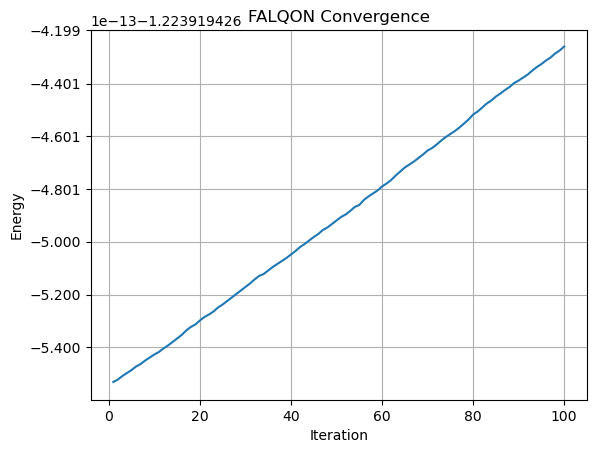

In [26]:
n = 100
beta_1 = 1
delta_t = 0.03

res_beta, res_energies = falqon_qiskit(n, beta_1, delta_t, cost_h_expanded, driver_h)

plt.plot(range(1, n+1), res_energies)
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("FALQON Convergence")
plt.grid()
plt.show()
